<a href="https://colab.research.google.com/github/akshant6/Denoising-Project/blob/main/VLG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
from glob import glob
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.layers import Input,Conv2D,Concatenate
from keras.models import Model
import tensorflow as tf

# **FUNCTION NEEDED BEFORE GENERATING DATA FROM FOLDERS.**








In [ ]:
def load_data(image_path):
    pic = tf.io.read_file(image_path)
    pic = tf.image.decode_png(pic, channels=3)
    pic = tf.image.resize(images=pic, size=[400, 400])
    pic = pic / 255.0  #scaling between [0,1]
    return pic

In [ ]:
def data_generator(low_light_images):
    data = tf.data.Dataset.from_tensor_slices((low_light_images))
    data = data.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    data = data.batch(16, drop_remainder=True)
    return data

# **SPLITTING DATASETS**

In [ ]:
# Load and sort image files for different datasets
train_images_low_light = sorted(glob("/content/drive/MyDrive/Train/low/*"))[:300]
validation_images_low_light = sorted(glob("/content/drive/MyDrive/Train/low/*"))[300:400]
test_images_low_light = sorted(glob("/content/drive/MyDrive/Train/low/*"))[400:485]
test_images_high_light = sorted(glob("/content/drive/MyDrive/Train/high/*"))[400:485]

# Generate datasets using the data generator
train_set = data_generator(train_images_low_light)
validation_set = data_generator(validation_images_low_light)

# Print the datasets
print("Training Dataset:", train_set)
print("Validation Dataset:", validation_set)

Training Dataset: <_BatchDataset element_spec=TensorSpec(shape=(16, 400, 400, 3), dtype=tf.float32, name=None)>
Validation Dataset: <_BatchDataset element_spec=TensorSpec(shape=(16, 400, 400, 3), dtype=tf.float32, name=None)>


In [ ]:
def Create_DCE_Network():
    input_image = Input(shape=[None, None, 3])
    layer1 = Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="same")(input_image)
    layer2 = Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="same")(layer1)
    layer3 = Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="same")(layer2)
    layer4 = Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="same")(layer3)

    concat1 = Concatenate(axis=-1)([layer4, layer3])
    layer5 = Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="same")(concat1)

    concat2 = Concatenate(axis=-1)([layer5, layer2])
    layer6 = Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="same")(concat2)

    concat3 = Concatenate(axis=-1)([layer6, layer1])
    output_layer = Conv2D(24, (3, 3), strides=(1, 1), activation="tanh", padding="same")(concat3)

    return Model(inputs=input_image, outputs=output_layer)

# **Our defined LOSS FUNCTIONS**

In [ ]:
def color_balance_loss(input_image):

    mean_channels = tf.reduce_mean(input_image, axis=(1, 2), keepdims=True)

    mean_red, mean_green, mean_blue = (
        mean_channels[:, :, :, 0],  # Mean value for the red channel
        mean_channels[:, :, :, 1],  # Mean value for the green channel
        mean_channels[:, :, :, 2],  # Mean value for the blue channel
    )
    diff_red_green = tf.square(mean_red - mean_green)
    diff_red_blue = tf.square(mean_red - mean_blue)
    diff_green_blue = tf.square(mean_green - mean_blue)

    # Compute the color constancy loss as the square root of the sum of squared differences
    loss_color_balance = tf.sqrt(tf.square(diff_red_green) + tf.square(diff_red_blue) + tf.square(diff_green_blue))

    return loss_color_balance


def brightness_loss(input_image, target_level=0.6):
    avg_intensity = tf.reduce_mean(input_image, axis=3, keepdims=True)
    pooled_mean = tf.nn.avg_pool2d(avg_intensity, ksize=16, strides=16, padding="VALID")
    loss_exposure = tf.reduce_mean(tf.square(pooled_mean - target_level))
    return loss_exposure


def smoothness_loss(input_tensor):
    num_batches = tf.shape(input_tensor)[0]
    height = tf.shape(input_tensor)[1]
    width = tf.shape(input_tensor)[2]
    num_h_elements = (width - 1) * tf.shape(input_tensor)[3]
    num_w_elements = width * (tf.shape(input_tensor)[3] - 1)
    vertical_diff = tf.reduce_sum(tf.square(input_tensor[:, 1:, :, :] - input_tensor[:, :height - 1, :, :]))
    horizontal_diff = tf.reduce_sum(tf.square(input_tensor[:, :, 1:, :] - input_tensor[:, :, :width - 1, :]))
    num_batches = tf.cast(num_batches, dtype=tf.float32)
    num_h_elements = tf.cast(num_h_elements, dtype=tf.float32)
    num_w_elements = tf.cast(num_w_elements, dtype=tf.float32)
    return 2 * (vertical_diff / num_h_elements + horizontal_diff / num_w_elements) / num_batches



# **CUSTOMIZING THE PROPERTIES OF A ZERO DCE MODEL.**

In [ ]:
class ZeroDCE(keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.dce_model = Create_DCE_Network()

    def compile(self, learning_rate, **kwargs):
        super().compile(**kwargs)
        self.optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.illumination_smoothness_loss_tracker = keras.metrics.Mean(name="illumination_smoothness_loss")
        self.color_constancy_loss_tracker = keras.metrics.Mean(name="color_constancy_loss")
        self.exposure_loss_tracker = keras.metrics.Mean(name="exposure_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.illumination_smoothness_loss_tracker,
            self.color_constancy_loss_tracker,
            self.exposure_loss_tracker,
        ]

    def get_enhanced_image(self, input_data, output):
        r1 = output[:, :, :, :3]
        r2 = output[:, :, :, 3:6]
        r3 = output[:, :, :, 6:9]
        r4 = output[:, :, :, 9:12]
        r5 = output[:, :, :, 12:15]
        r6 = output[:, :, :, 15:18]
        r7 = output[:, :, :, 18:21]
        r8 = output[:, :, :, 21:24]
        x = input_data + r1 * (tf.square(input_data) - input_data)
        x = x + r2 * (tf.square(x) - x)
        x = x + r3 * (tf.square(x) - x)
        enhanced_image = x + r4 * (tf.square(x) - x)
        x = enhanced_image + r5 * (tf.square(enhanced_image) - enhanced_image)
        x = x + r6 * (tf.square(x) - x)
        x = x + r7 * (tf.square(x) - x)
        enhanced_image = x + r8 * (tf.square(x) - x)
        return enhanced_image

    def call(self, input_data):
        dce_net_output = self.dce_model(input_data)
        return self.get_enhanced_image(input_data, dce_net_output)

    def compute_losses(self, input_data, output):
        enhanced_image = self.get_enhanced_image(input_data, output)
        loss_illumination = 200 * smoothness_loss(output)
        loss_color_constancy = 5 * tf.reduce_mean(color_balance_loss(enhanced_image))
        loss_exposure = 10 * tf.reduce_mean(brightness_loss(enhanced_image))
        total_loss = (loss_illumination + loss_color_constancy + loss_exposure)

        return {
            "total_loss": total_loss,
            "illumination_smoothness_loss": loss_illumination,
            "color_constancy_loss": loss_color_constancy,
            "exposure_loss": loss_exposure,
        }

    def train_step(self, data):
        with tf.GradientTape() as tape:
            output = self.dce_model(data)
            losses = self.compute_losses(data, output)

        gradients = tape.gradient(losses["total_loss"], self.dce_model.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.dce_model.trainable_weights))

        self.total_loss_tracker.update_state(losses["total_loss"])
        self.illumination_smoothness_loss_tracker.update_state(losses["illumination_smoothness_loss"])
        self.color_constancy_loss_tracker.update_state(losses["color_constancy_loss"])
        self.exposure_loss_tracker.update_state(losses["exposure_loss"])

        return {metric.name: metric.result() for metric in self.metrics}

    def test_step(self, data):
        output = self.dce_model(data)
        losses = self.compute_losses(data, output)

        self.total_loss_tracker.update_state(losses["total_loss"])
        self.illumination_smoothness_loss_tracker.update_state(losses["illumination_smoothness_loss"])
        self.color_constancy_loss_tracker.update_state(losses["color_constancy_loss"])
        self.exposure_loss_tracker.update_state(losses["exposure_loss"])

        return {metric.name: metric.result() for metric in self.metrics}

In [ ]:
enhancer_model = ZeroDCE()
enhancer_model.compile(learning_rate=1e-4)
enhancer_model.fit(train_set, validation_data=validation_set, epochs=40)

Epoch 1/40
18/18 [==============================] - 109s 2s/step - total_loss: 3.9594 - illumination_smoothness_loss: 0.9932 - color_constancy_loss: 0.0030 - exposure_loss: 2.9633 - val_total_loss: 3.7164 - val_illumination_smoothness_loss: 0.8069 - val_color_constancy_loss: 0.0012 - val_exposure_loss: 2.9083
Epoch 2/40
18/18 [==============================] - 38s 2s/step - total_loss: 3.4375 - illumination_smoothness_loss: 0.4866 - color_constancy_loss: 0.0031 - exposure_loss: 2.9477 - val_total_loss: 3.3765 - val_illumination_smoothness_loss: 0.4817 - val_color_constancy_loss: 0.0013 - val_exposure_loss: 2.8935
Epoch 3/40
18/18 [==============================] - 36s 2s/step - total_loss: 3.2557 - illumination_smoothness_loss: 0.3177 - color_constancy_loss: 0.0033 - exposure_loss: 2.9347 - val_total_loss: 3.2227 - val_illumination_smoothness_loss: 0.3406 - val_color_constancy_loss: 0.0014 - val_exposure_loss: 2.8807
Epoch 4/40
18/18 [==============================] - 38s 2s/step - tot

In [ ]:
def enhance_image(original_image):
    image = keras.utils.img_to_array(original_image)
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)
    output_image = enhancer_model(image)
    output_image = tf.cast((output_image[0, :, :, :] * 255), dtype=np.uint8)
    output_image = Image.fromarray(output_image.numpy())
    return output_image

# **Showing outcomes for five images**

In [ ]:
def display_images(images, titles, figure_size=(10, 10)):
    fig = plt.figure(figsize=figure_size)
    for i in range(len(images)):
        fig.add_subplot(1, len(images), i + 1).set_title(titles[i])
        _ = plt.imshow(images[i])
        plt.axis("off")
    plt.show()

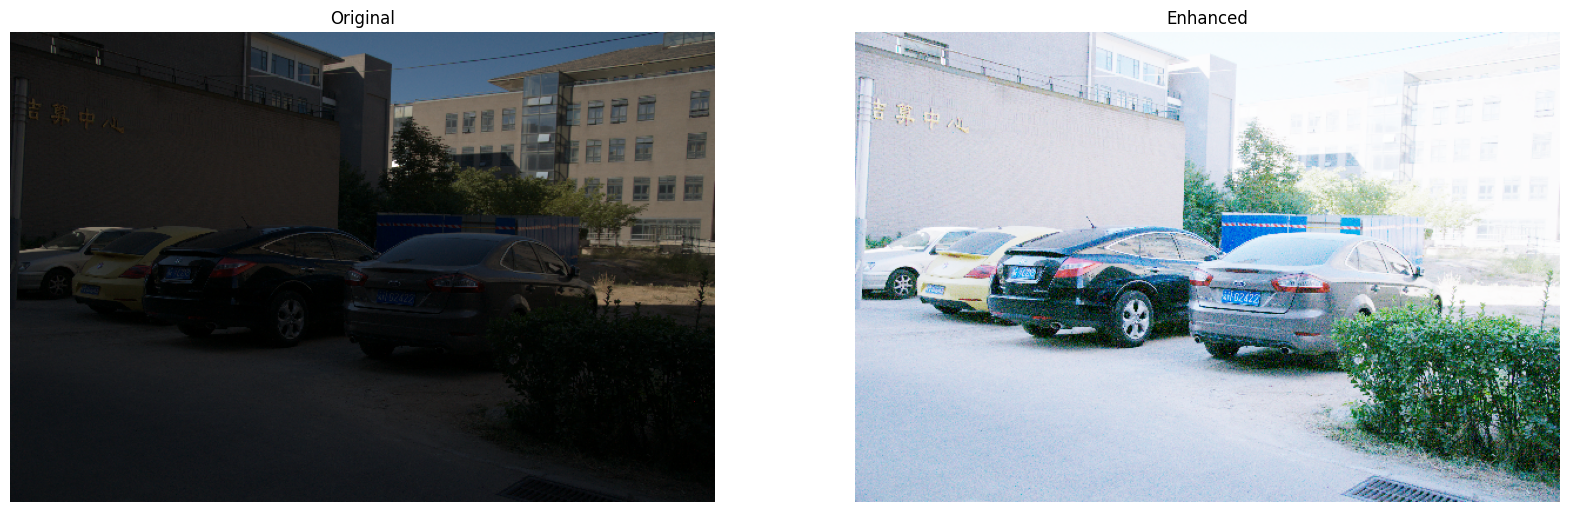

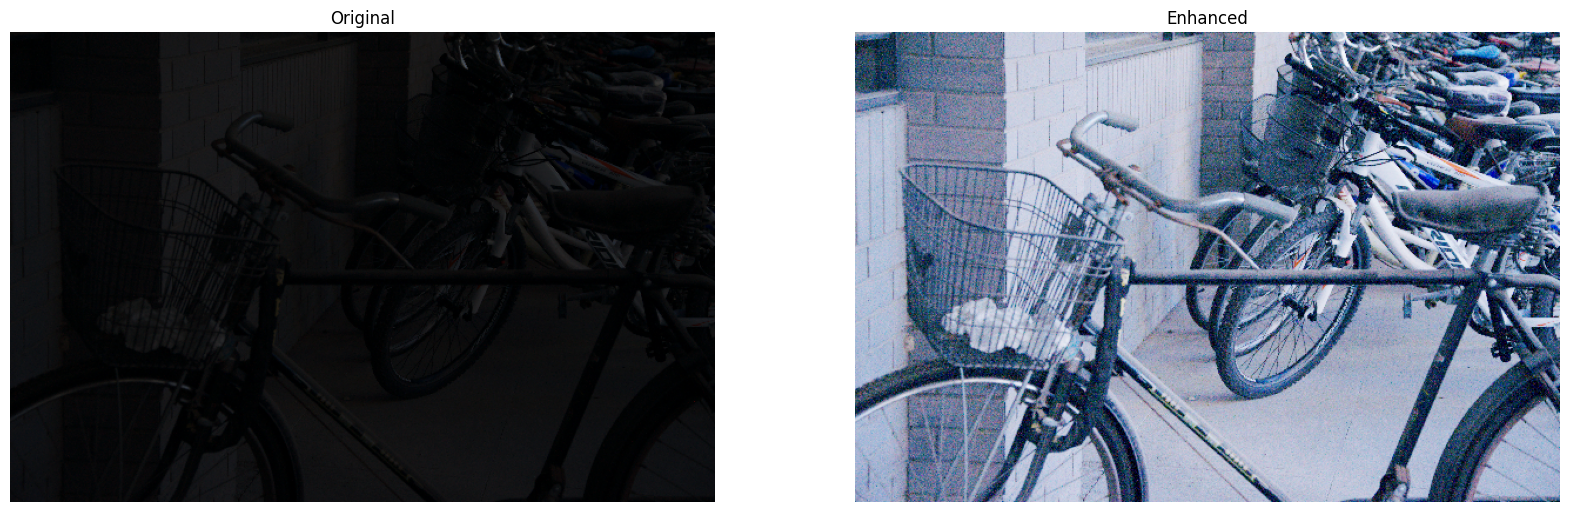

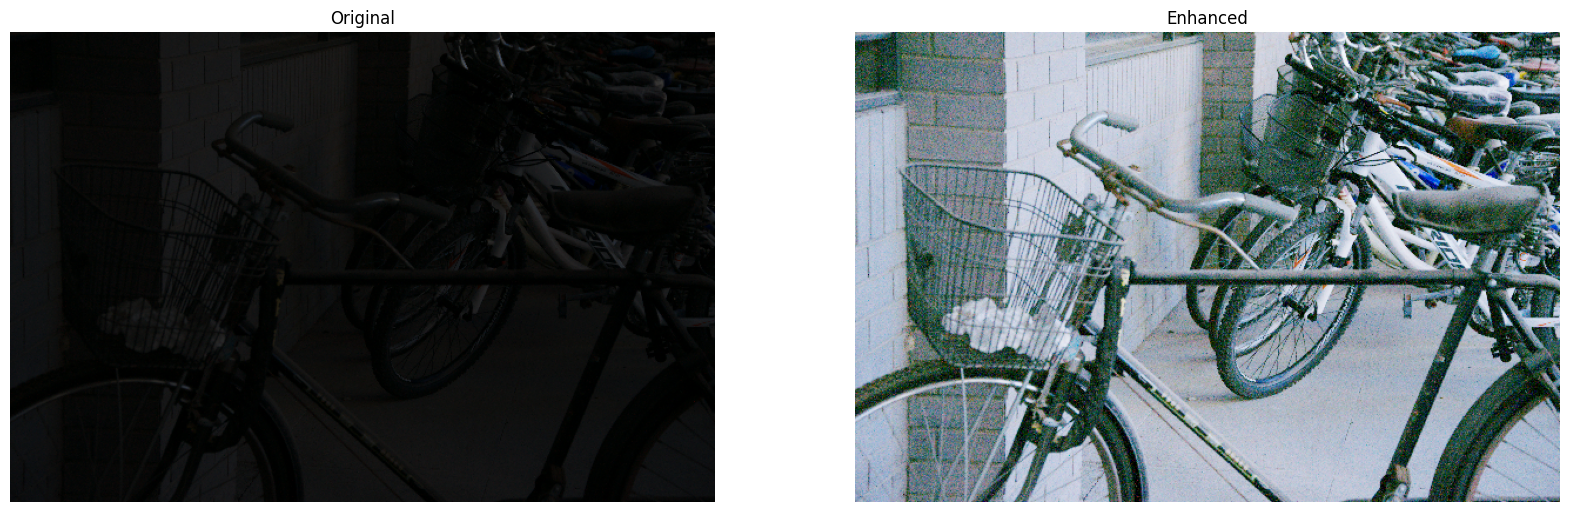

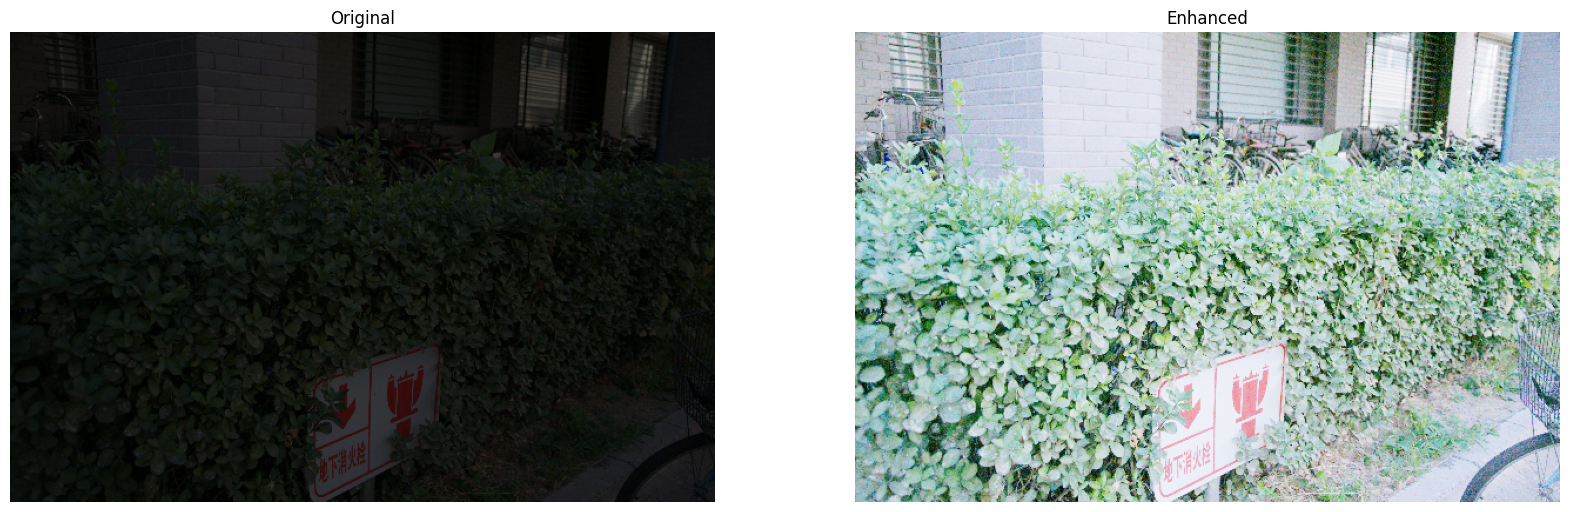

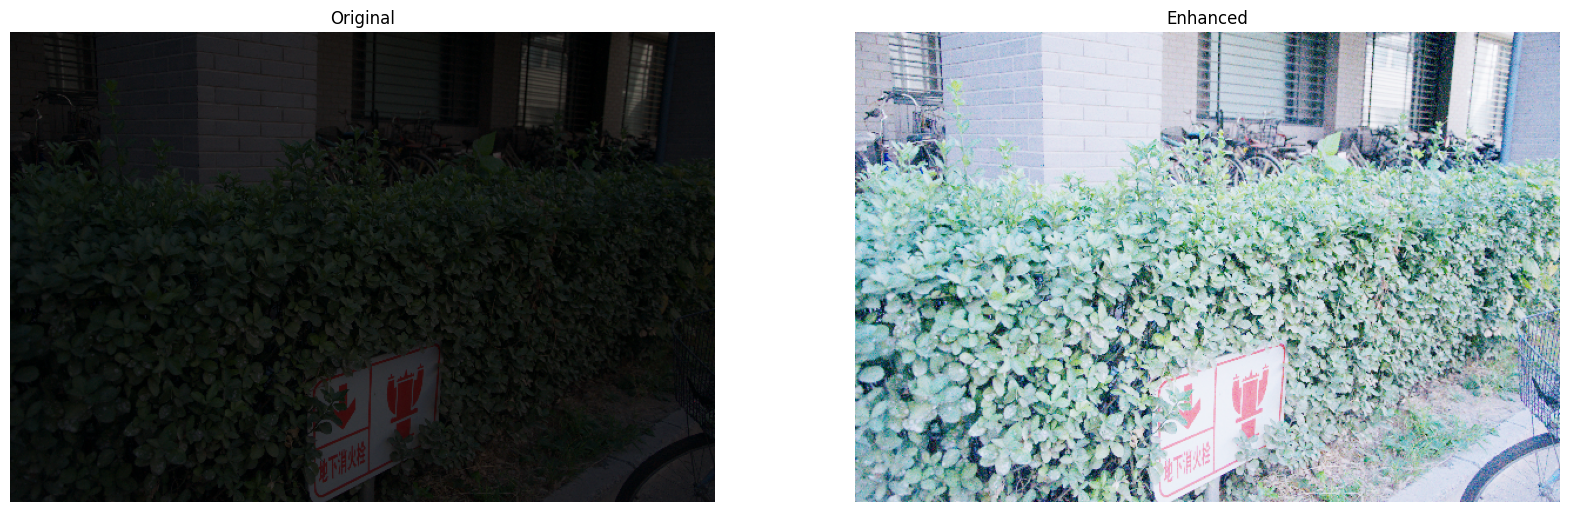

In [ ]:
for val_image_file in test_images_low_light[:5]:
    original_image = Image.open(val_image_file)
    enhanced_image = enhance_image(original_image)
    display_images(
        [original_image, enhanced_image],
        ["Original", "Enhanced"],
        (20, 12),
    )

# Calculating **PSNR** ratio

In [ ]:
def compute_psnr(original_image, enhanced_image):
    original_image = np.array(original_image)
    enhanced_image = np.array(enhanced_image)
    mse = np.mean((original_image - enhanced_image) ** 2)
    psnr = 10 * np.log10(255 ** 2 / mse)
    return psnr

In [ ]:
psnr_ratio = []
for i in range(len(test_images_low_light)):
    low_light_image = Image.open(test_images_low_light[i])
    enhanced_image = enhance_image(low_light_image)
    psnr = compute_psnr(low_light_image, enhanced_image)
    psnr_ratio.append(psnr)

In [ ]:
np.average(psnr_ratio)

27.966147730734242